In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [38]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(3*n/5)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 100

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += v
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return -sum(ens).real
    return gamma_beta_objective, history



<ipython-input-39-3a2e1d7ccf7f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


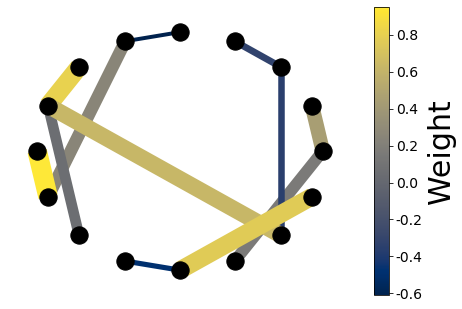

In [39]:
import matplotlib.pyplot as plt
pos=nx.circular_layout(graph)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
widths = [10+10*weights.get(edge, weights.get((edge[1], edge[0]))) for edge in graph.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(graph, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [40]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [41]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


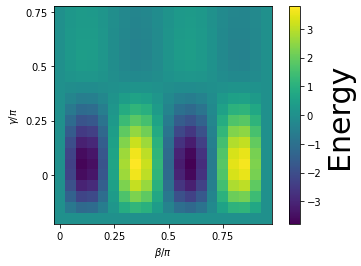

In [42]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [43]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [50]:
from tqdm import tqdm
MAX_ITERATION = 50
shots_per_point = BASELINE_SHOTS
fit_func1, history = expectation_objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [51]:
history, result = test_solver(oes)


  2%|▏         | 1/50 [00:00<00:44,  1.11it/s]

(array([ 0.2818643, -0.4192947]), 2.499813826708704, 2.499813826708704, 0.39269908169872414)


  4%|▍         | 2/50 [00:01<00:44,  1.09it/s]

(array([ 0.30476501, -0.08500699]), 0.5910956106096523, 0.5910956106096523, 0.39269908169872414)


  6%|▌         | 3/50 [00:02<00:43,  1.08it/s]

(array([-0.20006657,  0.35148915]), 1.7256032129268721, 1.7256032129268721, 0.39269908169872414)


  8%|▊         | 4/50 [00:03<00:42,  1.09it/s]

(array([-0.10773165,  0.22877014]), 0.6864517848792739, 0.6864517848792739, 0.39269908169872414)


 10%|█         | 5/50 [00:04<00:41,  1.08it/s]

(array([-0.2021293 ,  0.47799303]), 2.1999074355930492, 2.1999074355930492, 0.39269908169872414)


 12%|█▏        | 6/50 [00:05<00:42,  1.03it/s]

(array([-0.41715999,  0.64442875]), 3.5784053169919727, 3.5784053169919727, 0.39269908169872414)


 14%|█▍        | 7/50 [00:06<00:41,  1.03it/s]

(array([ 0.63915615, -0.38138648]), 1.419313178810372, 1.419313178810372, 0.39269908169872414)


 16%|█▌        | 8/50 [00:07<00:40,  1.04it/s]

(array([ 0.19425097, -0.57143994]), 2.380473661215678, 2.380473661215678, 0.39269908169872414)


 18%|█▊        | 9/50 [00:08<00:38,  1.07it/s]

(array([ 0.2543463 , -0.22158975]), 1.3571692115409963, 1.3571692115409963, 0.39269908169872414)


 20%|██        | 10/50 [00:09<00:38,  1.04it/s]

(array([ 0.04681727, -0.3047366 ]), 0.39642933874102143, 0.39642933874102143, 0.39269908169872414)


 22%|██▏       | 11/50 [00:10<00:36,  1.06it/s]

(array([ 0.62697875, -0.73293866]), 2.2185424861358727, 2.2185424861358727, 0.39269908169872414)


 24%|██▍       | 12/50 [00:11<00:37,  1.01it/s]

(array([ 0.25998481, -0.37987607]), 2.2096278190066196, 2.2096278190066196, 0.39269908169872414)


 26%|██▌       | 13/50 [00:12<00:35,  1.03it/s]

(array([ 0.12455133, -0.64163334]), 1.7150885691302784, 1.7150885691302784, 0.39269908169872414)


 28%|██▊       | 14/50 [00:13<00:34,  1.04it/s]

(array([ 0.50606809, -0.42561383]), 2.5158402123507972, 2.5158402123507972, 0.39269908169872414)


 30%|███       | 15/50 [00:14<00:33,  1.06it/s]

(array([-0.31683537,  0.52864048]), 3.0980426770714615, 3.0980426770714615, 0.39269908169872414)


 32%|███▏      | 16/50 [00:15<00:31,  1.06it/s]

(array([ 0.30858605, -1.06653906]), 3.2694996118543527, 3.2694996118543527, 0.39269908169872414)


 34%|███▍      | 17/50 [00:16<00:32,  1.03it/s]

(array([ 0.17672642, -0.44783372]), 1.887083895173589, 1.887083895173589, 0.39269908169872414)


 36%|███▌      | 18/50 [00:17<00:30,  1.05it/s]

(array([-0.34496325,  0.47385891]), 2.968641578206133, 2.968641578206133, 0.39269908169872414)


 38%|███▊      | 19/50 [00:18<00:29,  1.04it/s]

(array([-0.56739789,  0.59585686]), 2.6564881846503923, 2.6564881846503923, 0.39269908169872414)


 40%|████      | 20/50 [00:19<00:28,  1.05it/s]

(array([ 0.5644307 , -0.52572447]), 2.5016198288377076, 2.5016198288377076, 0.39269908169872414)


 42%|████▏     | 21/50 [00:19<00:27,  1.07it/s]

(array([-0.38043526,  0.16904395]), 1.2326167422849983, 1.2326167422849983, 0.39269908169872414)


 44%|████▍     | 22/50 [00:20<00:26,  1.07it/s]

(array([-0.47347167,  0.55445168]), 3.166035946068235, 3.166035946068235, 0.39269908169872414)


 46%|████▌     | 23/50 [00:22<00:26,  1.02it/s]

(array([ 0.33389404, -0.36186978]), 2.395508177109179, 2.395508177109179, 0.39269908169872414)


 48%|████▊     | 24/50 [00:22<00:25,  1.03it/s]

(array([-0.38470692,  0.67685808]), 3.660879755521614, 3.660879755521614, 0.39269908169872414)


 50%|█████     | 25/50 [00:23<00:24,  1.04it/s]

(array([-0.41885895,  0.85630839]), 3.770487182808805, 3.770487182808805, 0.39269908169872414)


 52%|█████▏    | 26/50 [00:24<00:22,  1.04it/s]

(array([ 0.77874067, -0.47531905]), 0.08067896931314118, 0.08067896931314118, 0.39269908169872414)


 54%|█████▍    | 27/50 [00:25<00:21,  1.06it/s]

(array([ 0.2039542 , -0.41002526]), 1.9813586511486811, 1.9813586511486811, 0.39269908169872414)


 56%|█████▌    | 28/50 [00:26<00:20,  1.08it/s]

(array([-0.33534577,  0.3273695 ]), 2.2058149233036453, 2.2058149233036453, 0.39269908169872414)


 58%|█████▊    | 29/50 [00:27<00:20,  1.05it/s]

(array([-0.29061253,  0.56787627]), 3.105395878028043, 3.105395878028043, 0.39269908169872414)


 60%|██████    | 30/50 [00:28<00:19,  1.05it/s]

(array([ 0.22190901, -0.6372257 ]), 2.7756881399761464, 2.7756881399761464, 0.39269908169872414)


 62%|██████▏   | 31/50 [00:29<00:17,  1.06it/s]

(array([-0.13301871,  0.74280534]), 1.9062290892699902, 1.9062290892699902, 0.39269908169872414)


 64%|██████▍   | 32/50 [00:30<00:16,  1.06it/s]

(array([-0.34634136,  1.01243183]), 3.529617888555926, 3.529617888555926, 0.39269908169872414)


 66%|██████▌   | 33/50 [00:31<00:16,  1.05it/s]

(array([-0.11333771,  0.33961999]), 1.0234704516564912, 1.0234704516564912, 0.39269908169872414)


 68%|██████▊   | 34/50 [00:32<00:15,  1.02it/s]

(array([-0.44826551,  0.49822892]), 3.050166517726768, 3.050166517726768, 0.39269908169872414)


 70%|███████   | 35/50 [00:33<00:14,  1.04it/s]

(array([-0.18539355,  0.22301798]), 1.0840123935242496, 1.0840123935242496, 0.39269908169872414)


 72%|███████▏  | 36/50 [00:34<00:13,  1.06it/s]

(array([-0.32580754,  0.21955584]), 1.5253322246931131, 1.5253322246931131, 0.39269908169872414)


 74%|███████▍  | 37/50 [00:35<00:12,  1.06it/s]

(array([-0.40788535,  0.40896241]), 2.710150562075828, 2.710150562075828, 0.39269908169872414)


 76%|███████▌  | 38/50 [00:36<00:11,  1.06it/s]

(array([ 0.3359515 , -0.42248813]), 2.7118538294166306, 2.7118538294166306, 0.39269908169872414)


 78%|███████▊  | 39/50 [00:37<00:10,  1.05it/s]

(array([-0.31038671,  0.67451402]), 3.4618455804871466, 3.4618455804871466, 0.39269908169872414)


 80%|████████  | 40/50 [00:38<00:09,  1.03it/s]

(array([-0.46810305,  0.18479492]), 1.2833210999712015, 1.2833210999712015, 0.39269908169872414)


 82%|████████▏ | 41/50 [00:39<00:08,  1.04it/s]

(array([ 0.15645245, -0.46636667]), 1.751632045497508, 1.751632045497508, 0.39269908169872414)


 84%|████████▍ | 42/50 [00:40<00:07,  1.03it/s]

(array([-0.28545195,  0.51891495]), 2.9186183734609275, 2.9186183734609275, 0.39269908169872414)


 86%|████████▌ | 43/50 [00:41<00:06,  1.03it/s]

(array([ 0.45445367, -0.48691698]), 2.9864253621606167, 2.9864253621606167, 0.39269908169872414)


 88%|████████▊ | 44/50 [00:42<00:05,  1.03it/s]

(array([-0.32090707,  1.06075102]), 3.336154825271085, 3.336154825271085, 0.39269908169872414)


 90%|█████████ | 45/50 [00:43<00:04,  1.00it/s]

(array([ 0.63203896, -0.31756368]), 1.2704448555191252, 1.2704448555191252, 0.39269908169872414)


 92%|█████████▏| 46/50 [00:44<00:04,  1.02s/it]

(array([ 0.36042864, -0.27398292]), 1.9217444433533917, 1.9217444433533917, 0.39269908169872414)


 94%|█████████▍| 47/50 [00:45<00:03,  1.01s/it]

(array([-0.51556777,  0.55890857]), 2.9569381554430483, 2.9569381554430483, 0.39269908169872414)


 96%|█████████▌| 48/50 [00:46<00:02,  1.01s/it]

(array([ 0.19986713, -0.94044754]), 2.664628929353381, 2.664628929353381, 0.39269908169872414)


 98%|█████████▊| 49/50 [00:47<00:00,  1.02it/s]

(array([ 0.241207  , -0.39753075]), 2.1831883239615895, 2.1831883239615895, 0.39269908169872414)


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]

(array([-0.29285041,  0.32633434]), 2.0812523999947277, 2.0812523999947277, 0.39269908169872414)
local optimum discovered by solver:
 [-0.29285041  0.32633434]
fitness score at this local optimum: 2.0812523999947277


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


([<matplotlib.axis.YTick at 0x7fb4e14af6d0>,
 [Text(0, 0.0, '0.75'),
  Text(0, 5.0, '0.5'),
  Text(0, 10.0, '0.25'),
  Text(0, 15.0, '0')])

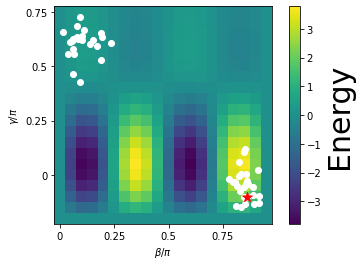

In [52]:
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.scatter([result[0][0]%(bound)*(samples-1)/(bound)], [(bound - (result[0][1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])

# Annealing

In [48]:
shots_per_point = NPOPULATION*BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result2 = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10,
    maxfun=one_hour*reprate,
    seed=1)
result2.fun = result2.fun
(result2.x, result2.fun)        

(array([1.43150866, 1.29356642]), -1.9487100626660767)

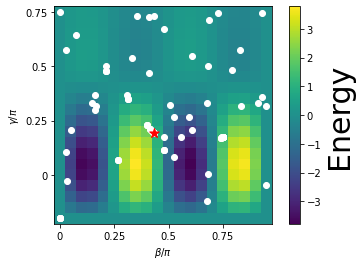

In [49]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2, c='w')
plt.scatter([result2.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result2.x[1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.imshow(all_data)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])
cb = plt.colorbar()
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
cb.set_label('Energy', fontsize=30)

In [34]:
len(x2)/10

15.8

In [19]:
weights

{(12, 2): 0.45464230847033815,
 (13, 6): -0.3199301160907462,
 (9, 4): -0.6049936872140034,
 (19, 14): 0.8183591856791752,
 (1, 16): 0.9566939700302572,
 (14, 8): 0.06560508821217659,
 (7, 5): -0.48173630126208833,
 (18, 12): 0.16762523765061044,
 (15, 13): -0.3486186941327827,
 (5, 11): 0.7777986275526183,
 (4, 16): 0.25280905351285,
 (14, 15): 0.6377473811556369}

In [37]:
expectation_objective(graph)[0]((np.array([1.43150866, 1.29356642])))

-1.4231683424570827